# 03_paddock-ts
### Purpose:
Combine segmented paddocks with Sentinel data downloaded for a region, extract paddock-level time series.

### Inputs
- stub name should correspond to a *filt.gpkg and a _ds2.pkl

### Outputs
- The pvt array represents paddocks by variable by time. variables can be spectral bands or derived indices. Saved as a numpy array. 
- TBD: pvt_weekly, or list of pandas dataframes with weekly resampled time series variables. It's easiest to resample a pd dataframe, but might be better for storage to convert back to numpy array... 
- 'Flipbook': series of plots or animations (TBD) showing time series variables for every paddock. This can potentially be used to label what's happening on ground.

### Other:
Not sure if time series clustering will be included in this script, or elsewhere... 


In [25]:
import geopandas as gpd
import pandas as pd
import numpy as np
import pickle
import xarray as xr
import rioxarray  # activate the rio accessor



In [5]:
stub = 'fm_ndwi_5'
out_dir = '/g/data/xe2/John/Data/PadSeg/'

<Axes: >

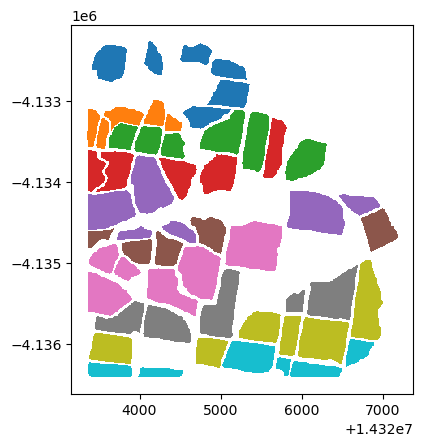

In [6]:
# read in the polygons and plot:
pol = gpd.read_file(out_dir+stub+'_filt.gpkg')
pol['paddock'] = range(1,len(pol)+1)
pol['paddock'] = pol.paddock.astype('category')
pol.plot(column = 'paddock')

In [11]:
## Open the satellite data stack
with open(out_dir+stub+'_ds2.pkl', 'rb') as handle:
    ds = pickle.load(handle)
ds

<xarray.Dataset>
Dimensions:                     (time: 236, y: 424, x: 386)
Coordinates:
  * time                        (time) datetime64[ns] 2019-01-05T00:06:11.826...
  * y                           (y) float64 -4.132e+06 -4.132e+06 ... -4.136e+06
  * x                           (x) float64 1.432e+07 1.432e+07 ... 1.433e+07
    spatial_ref                 int32 6933
Data variables: (12/41)
    nbart_coastal_aerosol       (time, y, x) float32 681.0 681.0 ... 349.0 349.0
    nbart_blue                  (time, y, x) float32 800.0 780.0 ... 413.0 463.0
    nbart_green                 (time, y, x) float32 1.091e+03 ... 763.0
    nbart_red                   (time, y, x) float32 1.456e+03 ... 901.0
    nbart_red_edge_1            (time, y, x) float32 1.587e+03 ... 1.443e+03
    nbart_red_edge_2            (time, y, x) float32 1.822e+03 ... 2.131e+03
    ...                          ...
    MNDWI                       (time, y, x) float32 -0.5296 -0.5254 ... -0.5501
    NBR                         (time, y, x) float32 -0.06708 ... 0.2698
    NDCI                        (time, y, x) float32 0.04305 0.05765 ... 0.2312
    NDTI                        (time, y, x) float32 0.1616 0.1616 ... 0.2463
    BSI                         (time, y, x) float32 0.2443 0.2499 ... 0.04469
    NDYI                        (time, y, x) float32 0.1539 0.172 ... 0.2447
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [95]:
def drop_oa(ds):
    '''Subset the list of variables in an xarray object to then filter it'''
    l = list(ds.keys())
    l = [item for item in l if 'oa' not in item]
    #l = [item for item in l2 if 'nbart' not in item]
    print('Keeping vars:', l)
    print('Number of variables:', len(l))
    return l

keep_vars = drop_oa(ds)

Keeping vars: ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_red_edge_1', 'nbart_red_edge_2', 'nbart_red_edge_3', 'nbart_nir_1', 'nbart_nir_2', 'nbart_swir_2', 'nbart_swir_3', 'NDVI', 'kNDVI', 'EVI', 'LAI', 'SAVI', 'MSAVI', 'NDMI', 'NDWI', 'MNDWI', 'NBR', 'NDCI', 'NDTI', 'BSI', 'NDYI']
Number of variables: 24


In [96]:
# Make paddock-variable-time (pvt) array:

# Loop through every polygon and extract the smoothed time series for some number of bands. 
ts = []
keep_vars = drop_oa(ds)
for datarow in pol.itertuples(index=True):
    #print(datarow)
    ds_ = ds[keep_vars]
    ds_clipped = ds_.rio.clip([datarow.geometry])
    pol_ts = ds_clipped.where(ds_clipped > 0).median(dim = ['x','y'])
    array = pol_ts.to_array().transpose('variable', 'time').values.astype(np.float32)
    ts.append(array[None,:] )
pvt = np.vstack(ts)

# save the pvt
np.save(out_dir+stub+'_pvt', pvt, allow_pickle=True, fix_imports=True)

# save the variable names:
with open(out_dir+stub+'_pvt_vars.pkl', 'wb') as f:
    pickle.dump(keep_vars, f)

Keeping vars: ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_red_edge_1', 'nbart_red_edge_2', 'nbart_red_edge_3', 'nbart_nir_1', 'nbart_nir_2', 'nbart_swir_2', 'nbart_swir_3', 'NDVI', 'kNDVI', 'EVI', 'LAI', 'SAVI', 'MSAVI', 'NDMI', 'NDWI', 'MNDWI', 'NBR', 'NDCI', 'NDTI', 'BSI', 'NDYI']
Number of variables: 24


In [97]:
pvt.shape

(56, 24, 236)

<Axes: >

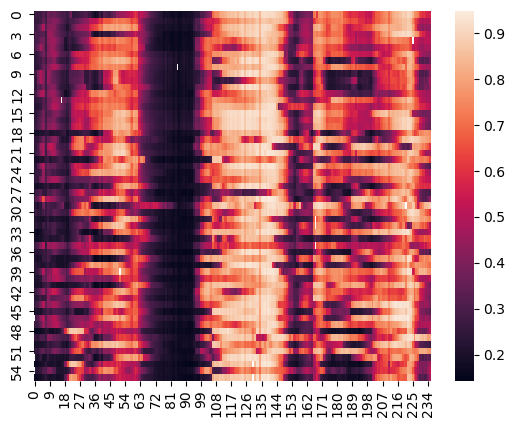

In [92]:
import seaborn as sns

i = keep_vars.index('NDVI')
#i = 3

pvt_ndvi = pvt[:,i,:]

sns.heatmap(pvt_ndvi)

In [105]:
long = reshape_to_long_df(pvt, keep_vars)
long

,paddock ID,time steps,variable,value
0,1,1,nbart_blue,872.000000
1,1,1,nbart_green,765.000000
2,1,1,nbart_red,728.000000
3,1,1,nbart_red_edge_1,628.000000
4,1,1,nbart_red_edge_2,688.000000
...,...,...,...,...
317179,56,236,NBR,0.183949
317180,56,236,NDCI,0.189427
317181,56,236,NDTI,0.182172
317182,56,236,BSI,0.186730


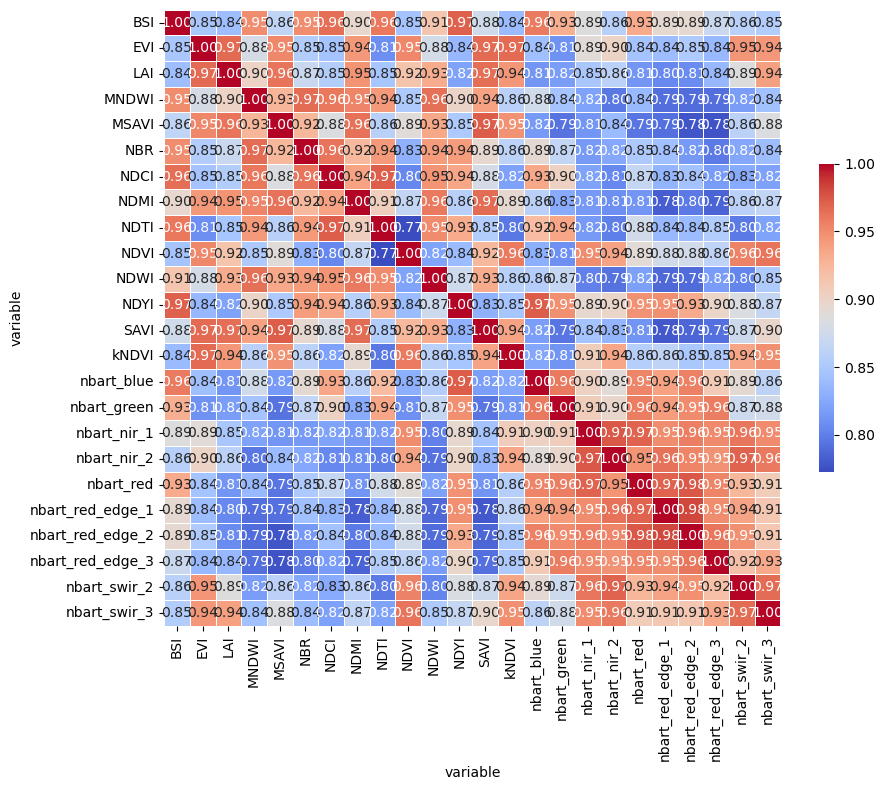

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
# First, pivot the DataFrame to have variables as columns, paddock IDs as rows, and values as values
pivot_df = long.pivot_table(index='paddock ID', columns='variable', values='value', aggfunc='mean')

# Calculate the correlation matrix
corr = pivot_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Show the plot
plt.show()
